<a href="https://colab.research.google.com/github/pravincoder/stock_bots/blob/main/Stock_transformer_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load your data
data = pd.read_csv('/content/drive/MyDrive/nifty50.csv')


# Strip whitespace from column names
data.columns = data.columns.str.strip()

# Normalize features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'Low', 'Close', 'High', 'Shares Traded', 'Turnover (₹ Cr)']])

# Fit a separate scaler for the Close prices
close_scaler = MinMaxScaler()
close_scaler.fit(data[['Close']])

# Create sequences for input and output
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 2])  # Close price
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define Transformer Model
def create_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Transformer Encoder
    for _ in range(8):  # Number of layers
        x = layers.MultiHeadAttention(num_heads=8, key_dim=128)(x, x)
        x = layers.LayerNormalization(epsilon=1e-5)(x + inputs)

        x = layers.Conv1D(filters=64, kernel_size=1, activation='relu')(x)
        x = layers.Conv1D(filters=input_shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-5)(x + inputs)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    return model

# Create and compile the model
model = create_transformer_model(X_train.shape[1:])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
5/5 [==============================] - 28s 2s/step - loss: 0.0536 - val_loss: 0.0329
Epoch 2/50
5/5 [==============================] - 4s 920ms/step - loss: 0.0271 - val_loss: 0.0563
Epoch 3/50
5/5 [==============================] - 4s 756ms/step - loss: 0.0209 - val_loss: 0.0259
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.0085 - val_loss: 0.0072
Epoch 5/50
5/5 [==============================] - 4s 870ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 6/50
5/5 [==============================] - 4s 800ms/step - loss: 0.0073 - val_loss: 0.0080
Epoch 7/50
5/5 [==============================] - 5s 975ms/step - loss: 0.0060 - val_loss: 0.0115
Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 0.0049 - val_loss: 0.0097
Epoch 9/50
5/5 [==============================] - 4s 855ms/step - loss: 0.0046 - val_loss: 0.0061
Epoch 10/50
5/5 [==============================] - 4s 879ms/step - loss: 0.0061 - val_loss: 0.0085
Epoch 11/50
5/5 [==========

In [150]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform to get original scale using close_scaler
y_pred_inverse = close_scaler.inverse_transform(y_pred)
y_test_inverse = close_scaler.inverse_transform(y_test.reshape(-1, 1))



2/2 [==============================] - 2s 700ms/step


In [154]:
predictions_df = pd.DataFrame({
    'Date': data['Date'][train_size + 30:].reset_index(drop=True),
    'Actual Close': y_test_inverse.flatten(),
    'Predicted Close': y_pred_inverse.flatten()
})

# Save to CSV
predictions_df.to_csv('predictions.csv', index=False)


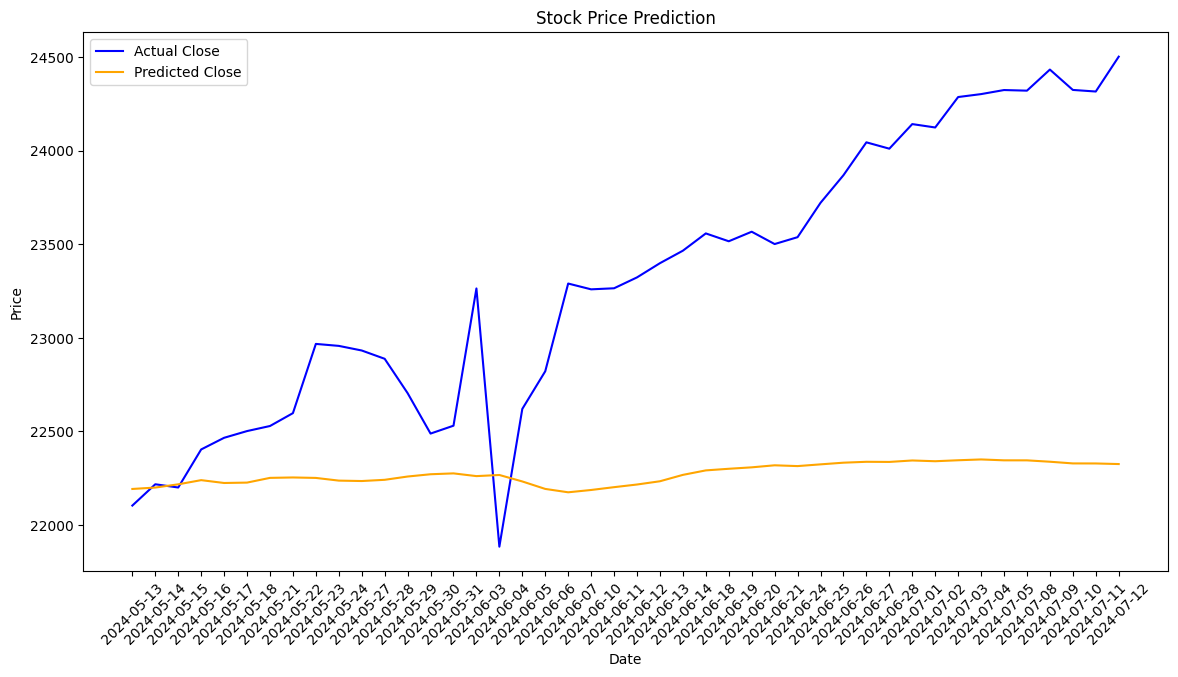

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(predictions_df['Date'], predictions_df['Actual Close'], label='Actual Close', color='blue')
plt.plot(predictions_df['Date'], predictions_df['Predicted Close'], label='Predicted Close', color='orange')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [129]:
# Fine tuning a Stock model using Base model of Bert
import pandas as pd

# Read data
df = pd.read_csv('/content/drive/MyDrive/nifty_data.csv')

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Convert the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')

# Convert the datetime format to 23-06-23
df['Date'] = df['Date'].dt.strftime('%d-%m-%y')

print(df.head())

df.isna().sum()

       Date      Open      High       Low     Close  Shares Traded  \
0  13-07-23  19495.20  19567.00  19385.80  19413.75      310442517   
1  14-07-23  19493.45  19595.35  19433.50  19564.50      291165841   
2  17-07-23  19612.15  19731.85  19562.95  19711.45      268707894   
3  18-07-23  19787.50  19819.45  19690.20  19749.25      286353897   
4  19-07-23  19802.95  19851.70  19727.45  19833.15      259660464   

   Turnover (₹ Cr)  
0         27244.56  
1         25484.44  
2         25975.57  
3         33269.08  
4         26447.90  


Date               0
Open               0
High               0
Low                0
Close              0
Shares Traded      0
Turnover (₹ Cr)    0
dtype: int64

In [130]:
# Sort data by date
df.sort_values(by='Date', inplace=True) # Date is actually date

In [131]:
# Drop the Date column for training
dates = df['Date']
data = df.drop(columns=['Date'])

In [132]:
#from sklearn.preprocessing import MinMaxScaler
# Normalize the data
#scaler = MinMaxScaler()
#scaled_df = scaler.fit_transform(data)
#scaled_df[0]

In [133]:
def create_sequences(data, window_size):
  '''
  To create input-output pairs of sequences from the provided data for training a machine learning model.
  Data : Dataframe/csv data
  window_size : Number of sequence to be used for training the model
  Example :
    Input :
    data = [
        [1, 2, 3, 100],  # Close price is 100
        [4, 5, 6, 110],  # Close price is 110
        [7, 8, 9, 120],  # Close price is 120
        [10, 11, 12, 130]  # Close price is 130
    ]
    window_size : 2
    Output :
    sequences = [
    ([[1, 2, 3, 100], [4, 5, 6, 110]], 120),
    ([[4, 5, 6, 110], [7, 8, 9, 120]], 130)
    ]

  '''
  X = []
  y = []
  for i in range(len(data)-window_size):
    seq = (data[i:i+window_size])
    label = (data[i+window_size][3])
    X.append(seq)
    y.append(label)
  sequences = list(zip(X,y))
  return sequences, X, y


In [134]:
# Using the last 60 days to predict the next day's price
window_size = 30

# Create sequences
sequences , X, y = create_sequences(data.values,window_size)

In [135]:
import torch
X,y = zip(*sequences)



In [136]:
import torch
from torch.utils.data import Dataset, DataLoader,random_split

class StockDataset(Dataset):
    def __init__(self, X, y):

        self.X = torch.tensor(X, dtype=torch.float32)  # Shape: (num_samples, num_days, num_features)
        self.y = torch.tensor(y, dtype=torch.float32)  # Shape: (num_samples,)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def split(self,train_ratio= 0.8):
        train_size = int(train_ratio * len(self))
        val_size = len(self) - train_size
        train_dataset, val_dataset = random_split(self, [train_size, val_size])
        return train_dataset, val_dataset


In [137]:
# Create dataset
dataset = StockDataset(X, y)

train_dataset, val_dataset = dataset.split()

# Now you can create DataLoaders if needed
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [138]:
for X_batch, y_batch in train_loader:


  print(X_batch.shape)

  # Reshape y_batch to tgt
  tgt = y_batch.unsqueeze(1).expand(-1, batch_size)  # Shape: (Output_price, batch_size, num_features)
  tgt = tgt.unsqueeze(-1)
  tgt = tgt.expand(-1, -1, num_features)   # Shape: (Output_price, batch_size, num_features)
  print(tgt.shape)

torch.Size([32, 30, 6])
torch.Size([32, 30, 6])
torch.Size([32, 30, 6])
torch.Size([32, 30, 6])
torch.Size([32, 30, 6])
torch.Size([32, 30, 6])
torch.Size([32, 30, 6])
torch.Size([32, 30, 6])
torch.Size([32, 30, 6])
torch.Size([32, 30, 6])
torch.Size([15, 30, 6])
torch.Size([15, 30, 6])


In [139]:
import torch
import torch.nn as nn
import torch.optim as optim

class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, out_price):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, 1)  # Output layer for final prediction
        self.out_price = out_price  # Number of output prices to predict

    def forward(self, src, tgt):
        # src shape: (seq_len, batch_size, num_features)
        # tgt shape: (out_price, batch_size, num_features)

        # Pass the inputs through the Transformer
        transformer_out = self.transformer(src, tgt)

        # Extract the output for the last time step
        output = self.fc(transformer_out[-1])  # Use the last output for prediction

        return output  # Shape: (batch_size, 1)

# Hyperparameters
input_dim = 6         # Number of features/input columns
hidden_dim = 128      # Hidden dimension size
num_layers = 4        # Number of layers in the Transformer
num_heads = 8         # Number of attention heads
out_price = 30        # Number of output prices to predict (i.e., next 30 days)

# Model instantiation
model = TransformerModel(input_dim, hidden_dim, num_layers, num_heads, out_price)



In [140]:
# Training loop
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
num_epochs = 50
for epochs in range(num_epochs):
  batch_size = X_batch.shape[1]  # Get the actual batch size
  num_features = 6
  model.train()
  optimizer.zero_grad()
  for X_batch, y_batch in train_loader:
    # Prepare src Shape: (num_days, batch_size, num_features)
    # Prepare tgt Shape :- ()

    # Reshape y_batch to tgt
    tgt = y_batch.unsqueeze(1).expand(-1, batch_size)
    tgt = tgt.unsqueeze(-1)
    tgt = tgt.expand(-1, -1, num_features)
    src = X_batch.permute(1, 0, 2)  # Shape: (price_days, batch_size, num_features)
    tgt = tgt.permute(1, 0, 2)  # Shape: (Output_price, batch_size, num_features)
    print(tgt.shape)
    print(src.shape)
    # Forward pass
    output = model(X_batch,tgt)
    loss = criterion(output.squeeze(), y_batch.unsqueeze(1))
    loss.backward()
    optimizer.step()

  # Validation loop
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for X_val, y_val in val_loader:
      val_outputs = model(X_val)
      val_loss += criterion(val_outputs, y_val.unsqueeze(-1)).item()

  avg_val_loss = val_loss / len(val_loader)
  print(f'Epoch [{epochs + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')


torch.Size([30, 32, 6])
torch.Size([30, 32, 6])


RuntimeError: the batch number of src and tgt must be equal

In [ ]:
# make prediction on validation set
model.eval()
with torch.no_grad():
  predictions = model(val_X, val_X).squeeze().numpy()
  actuals = val_y.numpy()

# Compare prededtions with actual value
comparison = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})
print(comparison.head())



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(predictions):], actuals, label='Actual')
plt.plot(data.index[-len(predictions):], predictions, label='Predicted')
plt.legend()
plt.show()


In [ ]:
data.values


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # Shape: (num_samples, num_days, num_features)
        self.y = torch.tensor(y, dtype=torch.float32)  # Shape: (num_samples,)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(d_model=input_dim, nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers)
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, src, tgt):
        transformer_out = self.transformer(src, tgt)
        output = self.fc(transformer_out[-1])  # Use the last output for prediction
        return output

def create_sequences(data, window_size):
    '''
    To create input-output pairs of sequences from the provided data for training a machine learning model.
    Data : Dataframe/csv data
    window_size : Number of sequences to be used for training the model
    Example :
        Input :
        data = [
            [1, 2, 3, 100],  # Close price is 100
            [4, 5, 6, 110],  # Close price is 110
            [7, 8, 9, 120],  # Close price is 120
            [10, 11, 12, 130]  # Close price is 130
        ]
        window_size : 2
        Output :
        sequences = [
            ([[1, 2, 3, 100], [4, 5, 6, 110]], 120),
            ([[4, 5, 6, 110], [7, 8, 9, 120]], 130)
        ]
    '''
    X = []
    y = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]  # Extract a window_size sequence
        label = data[i + window_size][3]  # Extract the target value (4th column)
        X.append(seq)
        y.append(label)

    # Convert lists to tensors
    X = torch.tensor(X, dtype=torch.float32)  # Shape: (num_samples, num_days, num_features)
    y = torch.tensor(y, dtype=torch.float32)  # Shape: (num_samples,)

    return X, y

# Hyperparameters
input_dim = 20  # No. of features/input columns
hidden_dim = 128
num_layers = 4
num_heads = 4
num_days = 30  # Example window size
batch_size = 16
num_epochs = 50
learning_rate = 0.01

# Sample data


# Create sequences
X, y = create_sequences(data.values, window_size)

# Create dataset
dataset = StockDataset(X, y)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model instantiation
model = TransformerModel(input_dim, hidden_dim, num_layers, num_heads)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for train_X, train_y in train_loader:
        optimizer.zero_grad()
        src = train_X.permute(1, 0, 2)  # Shape: (num_days, batch_size, num_features)
        tgt = train_X.permute(1, 0, 2)  # Use the same data as target input for simplicity

        output = model(src, tgt)
        loss = criterion(output.squeeze(), train_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            src = val_X.permute(1, 0, 2)  # Shape: (num_days, batch_size, num_features)
            tgt = val_X.permute(1, 0, 2)  # Use the same data as target input for simplicity
            val_output = model(src, tgt)
            val_loss += criterion(val_output.squeeze(), val_y).item()

    # Average losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
